In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from gensim.parsing.preprocessing import remove_stopwords
stop_words = set('for a of the and to in'.split())

In [7]:
df = pd.read_excel('final_dataset.xlsx', sheet_name='Sheet1')
df['split'] = np.random.randn(df.shape[0], 1)
msk = np.random.rand(len(df)) <= 0.7
train = df[msk]
test = df[~msk]

In [48]:
# Convert to list
data = df.Short_description.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [50]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
model = gensim.models.Word2Vec(data_words, size=200)
print(model)
from gensim.similarities.index import AnnoyIndexer

annoy_index = AnnoyIndexer(model,100)
vector = model['ended']
approximate_neighbors = model.most_similar([vector], topn=5, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)

Word2Vec(vocab=264, size=200, alpha=0.025)
('ended', 1.0)
('management', 0.79433374106884)
('an', 0.7637901306152344)
('dev', 0.7581171244382858)
('chm', 0.7527301907539368)


In [51]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/Users/sananda_jain/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [52]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #"""https://spacy.io/api/annotation"""
   # texts_out = []
   # for sent in texts:
    #    doc = nlp(" ".join(sent)) 
    #    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    #return texts_out

In [53]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# nlp = spacy.load('en', disable=['parser', 'ner']) -- error 
# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [54]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes()
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# human readable format of corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('fi', 1), ('finance', 1), ('with', 1)]]

In [55]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=id2word)

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_model[corpus],
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [56]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.183*"dev" + 0.125*"crm" + 0.098*"chm" + 0.096*"channel" + '
  '0.048*"management" + 0.040*"vistex" + 0.039*"ok" + 0.038*"redwood" + '
  '0.038*"not" + 0.035*"ca"'),
 (1,
  '0.193*"data" + 0.191*"archiving" + 0.121*"bpc" + 0.088*"redwood" + '
  '0.063*"nw" + 0.063*"epm" + 0.063*"atl" + 0.039*"prd" + 0.024*"process" + '
  '0.024*"not"'),
 (2,
  '0.211*"integration" + 0.211*"netweaver" + 0.205*"process" + 0.177*"pi" + '
  '0.037*"ok" + 0.037*"not" + 0.036*"redwood" + 0.000*"was" + 0.000*"chain" + '
  '0.000*"custmail"'),
 (3,
  '0.178*"c_atlut" + 0.129*"zfico_h" + 0.117*"finance" + 0.117*"fi" + '
  '0.102*"zfico_a" + 0.067*"with" + 0.065*"killed" + 0.055*"zfico_c" + '
  '0.035*"wb_prfap" + 0.021*"unknown"'),
 (4,
  '0.185*"warehouse" + 0.185*"bw" + 0.185*"business" + 0.118*"not" + '
  '0.117*"ok" + 0.115*"redwood" + 0.079*"prd" + 0.000*"gtn" + 0.000*"c_sap" + '
  '0.000*"post"'),
 (5,
  '0.119*"create" + 0.096*"batch" + 0.088*"split" + 0.077*"sc" + '
  '0.070*"backlog" + 0.062*"

In [57]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.543679830755163

Coherence Score:  0.4666083172238619


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/sananda_jain/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.230637  0.144594       1        1  17.886982
19     0.213599  0.100993       2        1  14.737505
0      0.230296  0.190936       3        1  11.814720
12     0.242289 -0.210773       4        1  10.840074
10     0.201804  0.190046       5        1  10.685637
13     0.207455  0.190878       6        1   7.581995
9      0.165672 -0.220689       7        1   7.116055
7      0.185811 -0.192314       8        1   4.486459
16     0.184390 -0.223221       9        1   4.370298
5     -0.094713 -0.039037      10        1   1.896045
11    -0.203145 -0.007111      11        1   1.650673
4     -0.055478  0.100473      12        1   1.477666
15    -0.222818 -0.038053      13        1   1.309507
1     -0.228087 -0.003808      14        1   0.906559
18     0.032806 -0.090115      15        1   0.689009
2     -0.175147  0.168073      16        1   0.679792
17    -0.196479 -0.092562      17        1   0.609464
3     -0.245085 -0.002564      18        1   0.540063
14    -0.222278  0.032819      19        1   0.514189
6     -0.251529  0.001435      20        1   0.207306, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
19    Default  1640.000000           job  1640.000000  30.0000  30.0000
8     Default  1119.000000          with  1119.000000  29.0000  29.0000
3     Default  1436.000000         error  1436.000000  28.0000  28.0000
10    Default   326.000000        killed   326.000000  27.0000  27.0000
7     Default  1730.000000        status  1730.000000  26.0000  26.0000
28    Default  1011.000000           prd  1011.000000  25.0000  25.0000
12    Default   731.000000         being   731.000000  24.0000  24.0000
4     Default   589.000000            fi   589.000000  23.0000  23.0000
5     Default   589.000000       finance   589.000000  22.0000  22.0000
1     Default  1631.000000         ended  1631.000000  21.0000  21.0000
24    Default   711.000000           set   711.000000  20.0000  20.0000
94    Default   354.000000            pi   354.000000  19.0000  19.0000
58    Default   412.000000       process   412.000000  18.0000  18.0000
29    Default   618.000000       redwood   618.000000  17.0000  17.0000
20    Default   624.000000    management   624.000000  16.0000  16.0000
2     Default  1184.000000           erp  1184.000000  15.0000  15.0000
54    Default   459.000000         human   459.000000  14.0000  14.0000
53    Default   459.000000           hcm   459.000000  13.0000  13.0000
52    Default   459.000000       capital   459.000000  12.0000  12.0000
92    Default   318.000000   integration   318.000000  11.0000  11.0000
93    Default   318.000000     netweaver   318.000000  10.0000  10.0000
46    Default   526.000000  distribution   526.000000   9.0000   9.0000
50    Default   526.000000            sd   526.000000   8.0000   8.0000
22    Default   519.000000            ok   519.000000   7.0000   7.0000
49    Default   536.000000         sales   536.000000   6.0000   6.0000
21    Default   512.000000           not   512.000000   5.0000   5.0000
30    Default   305.000000     warehouse   305.000000   4.0000   4.0000
6     Default  2429.000000           sap  2429.000000   3.0000   3.0000
26    Default   301.000000      business   301.000000   2.0000   2.0000
27    Default   301.000000            bw   301.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
98    Topic20     0.038811        subcon     1.255081   2.7025  -7.4174
99    Topic20     0.038811            cc     1.255081   2.7025  -7.4174
103   Topic20     0.038811     sunnyvale     1.255081   2.7025  -7.4174
100   Topic20     0.038811   consignment     1.255081   2.7025  -7.4174
101   Topic20     0.038811       dresden     1.255081   2.7025  -7.4174
102   Topic20     0.038811    set

In [58]:
mallet_path = '/Users/sananda_jain/Downloads/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word)

In [59]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('sd', 0.1670061099796334),
   ('sales', 0.14392396469789545),
   ('distribution', 0.13985064494229463),
   ('set', 0.12559402579769177),
   ('delivery', 0.07399864222674814),
   ('create', 0.048879837067209775),
   ('creation', 0.0373387644263408),
   ('update', 0.03665987780040733),
   ('batch', 0.03394433129667346),
   ('split', 0.031907671418873046)]),
 (12,
  [('warehouse', 0.2595978062157221),
   ('bw', 0.2571602681291895),
   ('business', 0.2571602681291895),
   ('redwood', 0.22425350396099938),
   ('d_prfar', 0.001218769043266301),
   ('killed', 0.0006093845216331506),
   ('pgi', 0.0),
   ('zfico_e', 0.0),
   ('change', 0.0),
   ('zptp_rsnast', 0.0)]),
 (6,
  [('fi', 0.3110485573539761),
   ('finance', 0.2962702322308234),
   ('killed', 0.13089373680506686),
   ('zfico_a', 0.0422237860661506),
   ('zfico_e', 0.0422237860661506),
   ('d_non_sap_atlut', 0.03589021815622801),
   ('c_atlut', 0.03166783954961295),
   ('zfico_f', 0.022519352568613652),
   ('c_sap', 0.0133708

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [60]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

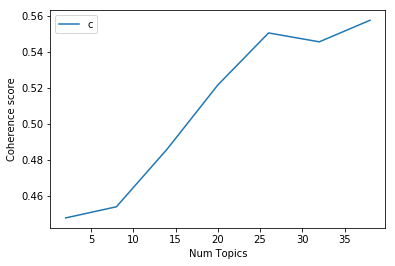

Num Topics = 2  has Coherence Value of 0.4479
Num Topics = 8  has Coherence Value of 0.454
Num Topics = 14  has Coherence Value of 0.486
Num Topics = 20  has Coherence Value of 0.5216
Num Topics = 26  has Coherence Value of 0.5505
Num Topics = 32  has Coherence Value of 0.5456
Num Topics = 38  has Coherence Value of 0.5575


In [61]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [62]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(12,
  '0.412*"finance" + 0.332*"fi" + 0.077*"zfico_a" + 0.068*"killed" + '
  '0.040*"zfico_f" + 0.023*"ca_prb" + 0.022*"c_sap_" + 0.012*"d_sap_atlut" + '
  '0.008*"d_prfar" + 0.006*"creation"'),
 (5,
  '0.308*"management" + 0.307*"hcm" + 0.197*"human" + 0.185*"capital" + '
  '0.001*"d_prfar" + 0.001*"posting" + 0.000*"scheduling" + '
  '0.000*"zptp_rsnast" + 0.000*"determi" + 0.000*"utility"'),
 (4,
  '0.200*"crm" + 0.179*"chm" + 0.172*"channel" + 0.161*"dev" + '
  '0.108*"management" + 0.040*"canceled" + 0.019*"ca" + 0.017*"billing" + '
  '0.015*"transfer" + 0.015*"doc"'),
 (2,
  '0.234*"distribution" + 0.148*"sd" + 0.133*"delivery" + 0.109*"sales" + '
  '0.089*"create" + 0.080*"set" + 0.062*"batch" + 0.058*"split" + 0.032*"prd" '
  '+ 0.020*"south"'),
 (3,
  '0.286*"bw" + 0.266*"warehouse" + 0.259*"business" + 0.189*"redwood" + '
  '0.000*"determi" + 0.000*"zptp_rsnast" + 0.000*"scheduling" + 0.000*"change" '
  '+ 0.000*"da_sap" + 0.000*"utility"'),
 (11,
  '0.258*"integration" + 0

In [44]:
# Finding dominant topic for each document:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0805,"ci, sap, error, status, ended, output, invoice...",(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATL...
1,1,6.0,0.1094,"fi, finance, erp, zfico_b, zfico_a, d_non_sap_...",(CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars...
2,2,8.0,0.1272,"job, sap, ci, crm, chm, channel, dev, ended, m...",(CI=SAP CRM CHM (Channel Management)) Job Ende...
3,3,9.0,0.1308,"killed, ended, status, ci, sap, c_atlut, bill,...",(CI=SAP CRM CHM (Channel Management)) Job Ende...
4,4,8.0,0.1053,"job, sap, ci, crm, chm, channel, dev, ended, m...",(CI=SAP BW(Business Warehouse))Redwood PRD: Jo...
5,5,7.0,0.1343,"job, redwood, warehouse, business, bw, prd, en...",(CI=SAP BPC NW EPM (Product & Cust Eng - PCE))...
6,6,12.0,0.1431,"redwood, ended, prd, bpc, sap, data, nw, epm, ...",(CI=SAP BPC NW EPM (Project Base Accounting - ...
7,7,6.0,0.1094,"fi, finance, erp, zfico_b, zfico_a, d_non_sap_...",(CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars...
8,8,12.0,0.1595,"redwood, ended, prd, bpc, sap, data, nw, epm, ...",(CI=SAP ERP SD (Sales and Distribution)) PRD: ...
9,9,1.0,0.1074,"job, error, prd, erp, set, info, status, ship,...",(CI=SAP HCM (Human Capital Management))ZHCM_OM...


In [92]:

unseen_document = 'Job ID: 47119402 being set to status Killed.'
data_words = list(sent_to_words(unseen_document))
texts = data_words
bow_vector = [id2word.doc2bow(text) for text in texts]
doc_lda = optimal_model[bow_vector]
#for text in texts:
#        doc_bow = id2word.doc2bow(text)
#        print(text)
#        topics = sorted(optimal_model[doc_bow],key=lambda x:x[1],reverse=True)
#        pprint(optimal_model.print_topics())
        
for index, score in sorted(optimal_model[doc_bow],key=lambda tup: -1*tup[1],reverse=True):
    print("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 5)))        

Score: 0.038461538461538464	 Topic: 0.202*"prd" + 0.202*"set" + 0.162*"sd" + 0.118*"creation" + 0.109*"sales"
Score: 0.038461538461538464	 Topic: 0.206*"sd" + 0.193*"sales" + 0.172*"distribution" + 0.166*"set" + 0.162*"prd"
Score: 0.038461538461538464	 Topic: 0.234*"distribution" + 0.148*"sd" + 0.133*"delivery" + 0.109*"sales" + 0.089*"create"
Score: 0.038461538461538464	 Topic: 0.286*"bw" + 0.266*"warehouse" + 0.259*"business" + 0.189*"redwood" + 0.000*"zptp_rsnast"
Score: 0.038461538461538464	 Topic: 0.200*"crm" + 0.179*"chm" + 0.172*"channel" + 0.161*"dev" + 0.108*"management"
Score: 0.038461538461538464	 Topic: 0.308*"management" + 0.307*"hcm" + 0.197*"human" + 0.185*"capital" + 0.001*"d_prfar"
Score: 0.038461538461538464	 Topic: 0.575*"redwood" + 0.256*"prd" + 0.140*"process" + 0.009*"deal" + 0.009*"compete"
Score: 0.038461538461538464	 Topic: 0.580*"prd" + 0.243*"set" + 0.064*"sales" + 0.059*"killed" + 0.019*"upload"
Score: 0.038461538461538464	 Topic: 0.224*"sd" + 0.212*"distrib